<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/Brain_tumer_data_CNN_%2B_ViT_%2B_GRU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !kaggle datasets download mohammadhossein77/brain-tumors-dataset

Dataset URL: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset
License(s): CC0-1.0
 91% 202M/221M [00:00<00:00, 581MB/s] 
100% 221M/221M [00:00<00:00, 620MB/s]


In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/MRI_DATA_IMAGE.zip'
extract_to = 'brain_tumor_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [6]:
batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/brain_tumor_data/MRI_DATA_IMAGE',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/brain_tumor_data/MRI_DATA_IMAGE',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1176 files belonging to 2 classes.
Using 941 files for training.
Found 1176 files belonging to 2 classes.
Using 235 files for validation.
Classes: ['Normal', 'Tumor Patient']


In [7]:
class ViTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(ViTBlock, self).__init__()
        self.norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.drop1 = layers.Dropout(dropout_rate)

        self.norm2 = layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim)
        ])
        self.drop2 = layers.Dropout(dropout_rate)

    def call(self, x):
        attn_out = self.attn(x, x)
        x = x + self.drop1(attn_out)
        x = self.norm1(x)
        mlp_out = self.mlp(x)
        x = x + self.drop2(mlp_out)
        return self.norm2(x)


In [8]:
def build_cnn_vit_gru(input_shape=(128, 128, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # CNN base
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    # Flatten spatial dims to sequence
    x = layers.Reshape((-1, 128))(x)  # shape = (batch, time_steps, features)

    # ViT Block
    x = ViTBlock(embed_dim=128, num_heads=4, mlp_dim=256)(x)

    # GRU
    x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)

    # Output
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [9]:
model = build_cnn_vit_gru()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_block (ViTBlock)           │ (None, 256, 128)       │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,500 (1.93 MB)

 Trainable params: 506,500 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.7205 - loss: 0.6913 - val_accuracy: 0.7745 - val_loss: 0.5337
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8207 - loss: 0.4777 - val_accuracy: 0.7745 - val_loss: 0.5521
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8213 - loss: 0.4826 - val_accuracy: 0.7745 - val_loss: 0.5355
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8143 - loss: 0.4853 - val_accuracy: 0.7745 - val_loss: 0.6016
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8225 - loss: 0.4868 - val_accuracy: 0.7745 - val_loss: 0.5239
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8072 - loss: 0.4773 - val_accuracy: 0.7745 - val_loss: 0.5331
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8159 - loss: 0.4484 - val_accuracy: 0.7787 - val_loss: 0.4828
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8144 - loss: 0.4535 - val_accuracy: 0.8043 - va

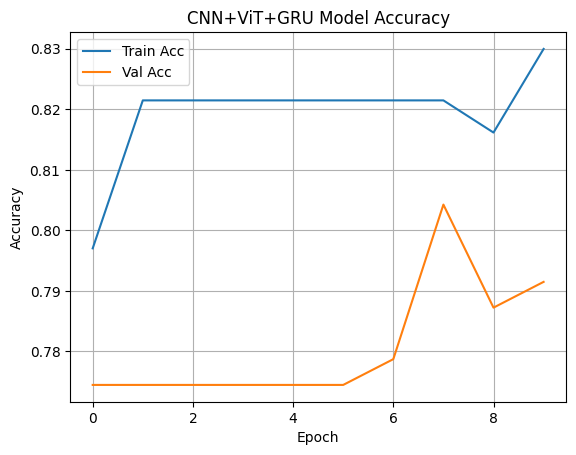

In [10]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN+ViT+GRU Model Accuracy')
plt.grid(True)
plt.show()
